# TP régression logistique et réseau de neurones

Le but de ce TP est de coder à la main un modèle de régression logistique et un réseau de neurones classique, en implémentant soit-même le calcul du gradient.

Nous allons tester nos implémentations sur le dataset [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist).

Rien ne vous est demandé à part l'implémentation des modèles. Je vous conseille tout de même de bien regarder la façon dont est structurée le reste du code car vous aurez à le faire vous-même pour les futurs TPs.

**Conseil général:**

- **Implémentez toutes les opérations à l'aide d'opérations matricielles.**
- **Pensez à bien vérifier les shapes des matrices que vous manipulez. L'analyse des shapes peut suffire pour déduire la bonne implémentation 90% du temps.**
- **Ce TP peut se faire sans utiliser une seule boucle for.**

In [ ]:
!pip install numpy matplotlib openml scikit-learn tqdm > /dev/null

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import openml
from sklearn.model_selection import train_test_split

dataset = openml.datasets.get_dataset("Fashion-MNIST")
df, _, _, _ = dataset.get_data()

df_train, df_test = train_test_split(df, test_size=0.20, random_state=0)

X_train, y_train = df_train.to_numpy()[:, :-1], df_train["class"].values
X_test, y_test = df_test.to_numpy()[:, :-1], df_test["class"].values

X_train, y_train = X_train.astype(int), y_train.astype(int)
X_test, y_test = X_test.astype(int), y_test.astype(int)

## Dataset

L'objet `Dataset` permet de charger des batchs de données aléatoires afin d'être utilisés lors de la SGD.

In [ ]:
from typing import Iterator


class Dataset:
    def __init__(self, X: np.ndarray, y: np.ndarray, n_classes: int = 10, seed: int = 0):
        self.X = X
        self.y = y
        self.n_classes = n_classes
        self.rng = np.random.default_rng(seed)

    def __getitem__(self, i: int) -> tuple[np.ndarray, np.ndarray]:
        """Fetch the given sample.

        ---
        Args:
            i: Sample id.

        ---
        Returns:
            x: The flattened image.
                Shape of [n_pixels,].
            y: The class of the image as a one-hot vector.
                Shape of [n_classes,].
        """
        x = self.X[i] / 255
        y = np.zeros(self.n_classes, float)
        y[self.y[i]] = 1
        return x, y

    def __len__(self) -> int:
        """Number of samples in the dataset."""
        return len(self.X)

    def iterate(self, batch_size: int) -> Iterator[tuple[np.ndarray, np.ndarray]]:
        """Returns an iterator going over all samples of the dataset in a random
        order.
        """
        indices = self.rng.permutation(len(self))
        for i in range(0, len(indices), batch_size):
            batch = range(i, min(i + batch_size, len(indices)))
            batch = [indices[j] for j in batch]
            batch = [self[j] for j in batch]
            batch = Dataset.collate_fn(batch)
            yield batch

    @staticmethod
    def collate_fn(batch: list[tuple[np.ndarray, np.ndarray]]) -> tuple[np.ndarray, np.ndarray]:
        """Stack a list of samples into a batch of numpy arrays.

        ---
        Args:
            batch: The list of (x, y) tuples.

        ---
        Returns:
            xs: The stacked images.
                Shape of [batch_size, n_pixels].
            ys: The stacked classes.
                Shape of [batch_size, n_classes].
        """
        xs = [b[0] for b in batch]
        ys = [b[1] for b in batch]

        xs = np.stack(xs)
        ys = np.stack(ys)
        return xs, ys

    @staticmethod
    def show_images(X: np.ndarray, y: np.ndarray, n_cols: int = 8, imsize: int = 28) -> plt.Figure:
        n_images = len(X)
        X = (X * 255).astype(int)
        X = X.reshape(n_images, imsize, imsize)
        y = np.argmax(y, axis=1)

        id_to_name = {
            0: "T-shirt/top",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle boot",
        }

        fig, axes = plt.subplots(n_images // n_cols, n_cols)
        for ax, xi, yi in zip(axes.flatten(), X, y):
            ax.imshow(xi, cmap='gray')
            ax.set_title(f"{id_to_name[yi]}")
            ax.set_xticks([])
            ax.set_yticks([])

        fig.tight_layout()
        return fig

train_dataset = Dataset(X_train, y_train, seed=0)
test_dataset = Dataset(X_test, y_test, seed=1)

print(f"Training size: {len(train_dataset):,}")
print(f"Testing size: {len(test_dataset):,}")

Training size: 56,000
Testing size: 14,000


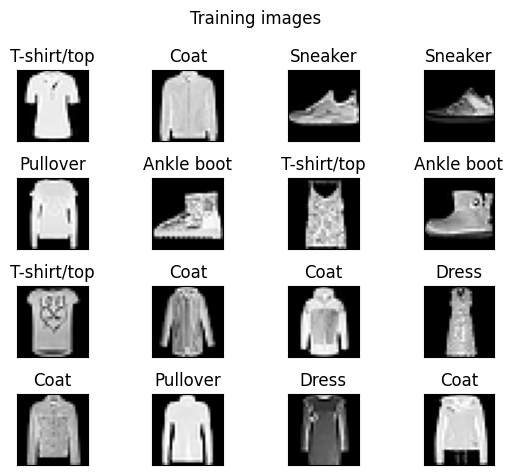

In [ ]:
X, y_true = next(iter(train_dataset.iterate(16)))
fig = Dataset.show_images(X, y_true, n_cols=4)
fig.suptitle("Training images")
fig.tight_layout()
plt.show(fig)

## Trainer

L'objet `Trainer` sert de coordinateur général pour entraîner le modèle sur plusieurs epochs et périodiquement l'évaluer sur le test set.

Vous devez implémenter les fonctions `accuracy` et `loss`.

In [ ]:
from tqdm.notebook import tqdm


class Trainer:
    def __init__(
        self,
        model,
        train_dataset: Dataset,
        test_dataset: Dataset,
        learning_rate: float,
        batch_size: int,
        n_epochs: int,
    ):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_epochs = n_epochs

    def train(self):
        """Train the model for one epoch using random batches of data."""
        for X, y_true in tqdm(
            self.train_dataset.iterate(self.batch_size),
            "Training steps",
            total=len(self.train_dataset) // self.batch_size + 1,
            leave=False,
        ):
            y_pred = self.model(X)
            grad = self.model.gradient(X, y_pred, y_true)
            self.model.update(grad, self.learning_rate)

    def eval(self, dataset: Dataset) -> dict[str, float]:
        """Evaluate the given dataset."""
        metrics = {
            "loss": [],
            "accuracy": [],
        }
        for X, y_true in tqdm(
            dataset.iterate(self.batch_size),
            "Evaluation steps",
            total=len(dataset) // self.batch_size + 1,
            leave=False,
        ):
            y_pred = self.model(X)
            metrics["loss"].append(self.loss(y_pred, y_true))
            metrics["accuracy"].append(self.accuracy(y_pred, y_true))

        metrics["loss"] = np.mean(metrics["loss"])
        metrics["accuracy"] = np.mean(metrics["accuracy"])
        return metrics

    def start(self) -> dict[str, list[float]]:
        """Launch the training.

        ---
        Returns:
            The metrics of the test set at each epoch.
        """
        metrics = {
            "loss": [],
            "accuracy": [],
            "epoch": [],
        }

        for e in tqdm(range(1, self.n_epochs + 1), "Epoch"):
            self.train()

            m = self.eval(self.test_dataset)
            metrics["loss"].append(m["loss"])
            metrics["accuracy"].append(m["accuracy"])
            metrics["epoch"].append(e)

        return metrics

    @staticmethod
    def accuracy(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        """Compute the accuracy.

        ---
        Args:
            y_pred: Model's predictions.
                Shape of [batch_size, n_classes].
            y_true: Ground truth.
                Shape of [batch_size, n_classes].

        ---
        Returns:
            The mean accuracy.
        """
        accuracies = np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1)
        return accuracies.mean()

    @staticmethod
    def loss(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        """Compute the cross-entropy loss.

        ---
        Args:
            y_pred: Model's predictions.
                Shape of [batch_size, n_classes].
            y_true: Ground truth.
                Shape of [batch_size, n_classes].

        ---
        Returns:
            The mean cross-entropy loss.
        """
        losses = -y_true * np.log(y_pred)
        return losses.sum(axis=1).mean()

## Régression logistique

La régression logistique peut être vue simplement comme un réseau de neurones à une seule couche. Le calcul du gradient ne nécessite pas de backpropagation.

Implémentez le forward, l'update et le calcul du gradient du modèle. Pour le calcul du gradient, on vous donne en input tout ce dont vous avez besoin.

In [ ]:
import math

from scipy.special import softmax


class LogisticModel:
    weights: np.ndarray

    def __init__(self, input_dim: int, n_classes: int, seed: int = 0):
        rng = np.random.default_rng(seed)
        lim = 1 / math.sqrt(input_dim)
        self.weights = rng.uniform(-lim, lim, (n_classes, input_dim + 1))

    def __call__(self, X: np.ndarray) -> np.ndarray:
        """Do the forward pass.

        ---
        Args:
            X: A batch of images.
                Shape of [batch_size, input_dim].

        ---
        Returns:
            The predictions.
                Shape of [batch_size, n_classes].
        """
        X = np.pad(X, [(0, 0), (0, 1)], constant_values=1)
        logits = X @ self.weights.T
        return softmax(logits, axis=1)

    def update(self, grad: np.ndarray, lr: float):
        """Update the weights based on the given gradient and learning rate.

        ---
        Args:
            grad: The gradient.
                Shape of `self.weights`.
            lr: The learning rate of the update.
        """
        self.weights = self.weights - lr * grad

    @staticmethod
    def gradient(X: np.ndarray, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        """Compute the gradient.

        ---
        Args:
            X: Batch of images.
                Shape of [batch_size, input_dim].
            y_pred: Model's predictions.
                Shape of [batch_size, n_classes].
            y_true: Ground truth.
                Shape of [batch_size, n_classes].

        ---
        Returns:
            The gradient.
                Shape of `self.weights`.
        """
        X = np.pad(X, [(0, 0), (0, 1)], constant_values=1)
        return -(y_true - y_pred).T @ X / len(X)

### Entraînement du modèle

Essayez plusieurs hyper-paramètres et observez l'impacte qu'ils sont sur l'entraînement du modèle.

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

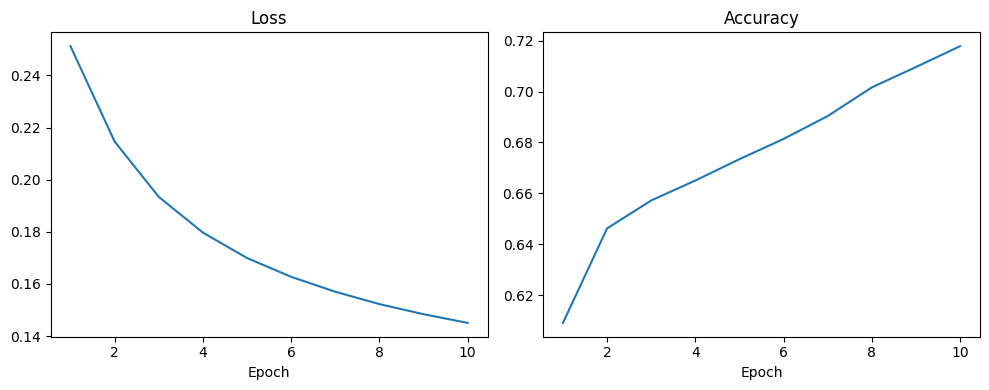

In [ ]:
x, y = train_dataset[0]
input_dim, n_classes = len(x), len(y)
model = LogisticModel(input_dim, n_classes)
lr = 1e-3
epochs = 10
batch_size = 128

trainer = Trainer(model, train_dataset, test_dataset, lr, batch_size, epochs)
metrics = trainer.start()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(metrics["epoch"], metrics["loss"])
axes[1].plot(metrics["epoch"], metrics["accuracy"])

axes[0].set_title("Loss")
axes[1].set_title("Accuracy")

axes[0].set_xlabel("Epoch")
axes[1].set_xlabel("Epoch")

fig.tight_layout()
plt.show(fig)

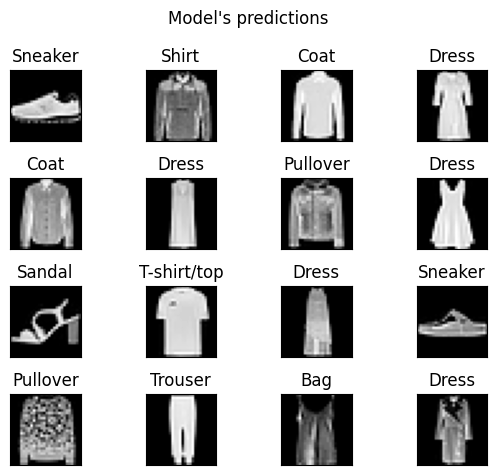

In [ ]:
x, y_true = next(iter(train_dataset.iterate(16)))
y_pred = model(x)
fig = train_dataset.show_images(x, y_pred, n_cols=4)
fig.suptitle("model's predictions")
fig.tight_layout()
plt.show(fig)

## Neural Network

Il faut maintenant passer au niveau supérieur en implémentant votre propre réseau de neurones. Pour cela vous aurez besoin d'implémenter la backpropagation.

Le modèle que vous implémentez est un simple MLP, avec un nombre variable de couches.

Implémentez le forward, l'update et le calcul du gradient du modèle.
Le calcul du gradient doit se faire en utiliser les équations de la backpropagation.

**Note:**

**Vous devez sauvegarder les activations intermédiaires lors du forward afin de les réutiliser lors du backward.**

In [ ]:
import math


class MLP:
    weights: list[np.ndarray]
    H: list[np.ndarray]  # Activations intermédiaires.

    def __init__(self, input_dim: int, n_classes: int, hidden_dim: int, n_layers: int, seed: int = 0):
        rng = np.random.default_rng(seed)

        def init_weight(input_dim: int, output_dim: int) -> np.ndarray:
            lim = 1 / math.sqrt(input_dim)
            return rng.uniform(-lim, lim, (output_dim, input_dim + 1))

        self.weights = (
            [init_weight(input_dim, hidden_dim)]
            + [init_weight(hidden_dim, hidden_dim) for _ in range(n_layers)]
            + [init_weight(hidden_dim, n_classes)]
        )
        self.H = []

    def __call__(self, X: np.ndarray) -> np.ndarray:
        """Do the forward pass. Save the intermediate computations for the
        backpropagation algorithm.

        ---
        Args:
            X: A batch of images.
                Shape of [batch_size, input_dim].

        ---
        Returns:
            The predictions.
                Shape of [batch_size, n_classes].
        """
        self.H = []
        for weight in self.weights[:-1]:
            self.H.append(X)
            X = np.pad(X, [(0, 0), (0, 1)], constant_values=1)
            A = X @ weight.T
            X = np.maximum(A, 0)

        self.H.append(X)
        X = np.pad(X, [(0, 0), (0, 1)], constant_values=1)
        A = X @ self.weights[-1].T
        return softmax(A, axis=1)

    def gradient(self, _, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        """Compute the gradient using the backpropagation rules.

        Remember to use the saved activations of the last forward pass.

        ---
        Args:
            _: Batch of images (ignored here).
            y_pred: Model's predictions.
                Shape of [batch_size, n_classes].
            y_true: Ground truth.
                Shape of [batch_size, n_classes].

        ---
        Returns:
            The gradient.
                Shape of `self.weights`.
        """
        grads = []
        batch_size = len(y_pred)
        delta = y_true - y_pred
        for weight, H in zip(reversed(self.weights), reversed(self.H)):
            Hb = np.pad(H, [(0, 0), (0, 1)], constant_values=1)
            grads.append(-delta.T @ Hb / batch_size)
            D = (H > 0).astype(float)
            delta = (delta @ weight[:, :-1]) * D

        grads = list(reversed(grads))
        return grads

    def update(self, grads: list[np.ndarray], lr: float):
        """Update the weights based on the given gradient and learning rate.

        ---
        Args:
            grad: The gradient.
                Shape of `self.weights`.
            lr: The learning rate of the update.
        """
        self.weights = [
            weight - lr * grad
            for weight, grad in zip(self.weights, grads)
        ]

### Entraînement du modèle

Pareil, vous pouvez tester plusieurs hyperparamètres. Ce modèle est encore plus sensible aux choix de vos hyperparamètres!

Commencez par quelque chose de simple (une seule couche cachée et lr faible).
Un bon modèle devrait être au moins aussi bon que votre régression logistique (mais il peut prendre plus de temps à s'entraîner !).

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

Training steps:   0%|          | 0/438 [00:00<?, ?it/s]

Evaluation steps:   0%|          | 0/110 [00:00<?, ?it/s]

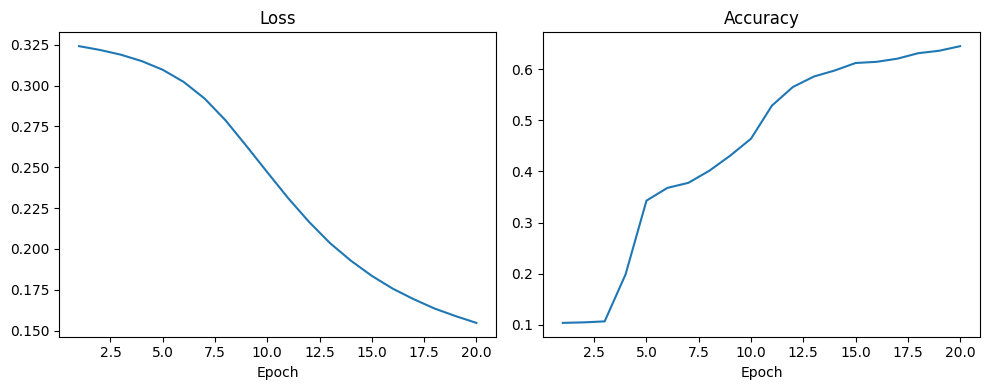

In [ ]:
x, y = train_dataset[0]
input_dim, n_classes = len(x), len(y)
model = MLP(input_dim, n_classes, 32, 1)
lr = 1e-3
epochs = 20
batch_size = 128

trainer = Trainer(model, train_dataset, test_dataset, lr, batch_size, epochs)
metrics = trainer.start()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(metrics["epoch"], metrics["loss"])
axes[1].plot(metrics["epoch"], metrics["accuracy"])

axes[0].set_title("Loss")
axes[1].set_title("Accuracy")

axes[0].set_xlabel("Epoch")
axes[1].set_xlabel("Epoch")

fig.tight_layout()
plt.show(fig)

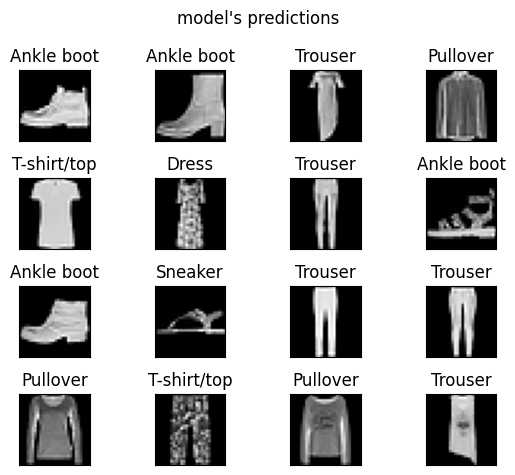

In [ ]:
x, y_true = next(iter(train_dataset.iterate(16)))
y_pred = model(x)
fig = train_dataset.show_images(x, y_pred, n_cols=4)
fig.suptitle("model's predictions")
fig.tight_layout()
plt.show(fig)